# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 2301952/11490434 [=====>........................] - ETA: 0s

 4497408/11490434 [==========>...................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:25 - loss: 0.6939

  27/1875 [..............................] - ETA: 3s - loss: 0.5572   

  56/1875 [..............................] - ETA: 3s - loss: 0.4719

  83/1875 [>.............................] - ETA: 3s - loss: 0.4302

 116/1875 [>.............................] - ETA: 3s - loss: 0.3986

 142/1875 [=>............................] - ETA: 3s - loss: 0.3808

 171/1875 [=>............................] - ETA: 3s - loss: 0.3653

 207/1875 [==>...........................] - ETA: 2s - loss: 0.3498

 242/1875 [==>...........................] - ETA: 2s - loss: 0.3375

 274/1875 [===>..........................] - ETA: 2s - loss: 0.3279

 297/1875 [===>..........................] - ETA: 2s - loss: 0.3218

 325/1875 [====>.........................] - ETA: 2s - loss: 0.3151

 353/1875 [====>.........................] - ETA: 2s - loss: 0.3089

 382/1875 [=====>........................] - ETA: 2s - loss: 0.3032

 410/1875 [=====>........................] - ETA: 2s - loss: 0.2981

 438/1875 [======>.......................] - ETA: 2s - loss: 0.2934

 466/1875 [======>.......................] - ETA: 2s - loss: 0.2890

 486/1875 [======>.......................] - ETA: 2s - loss: 0.2861

 514/1875 [=======>......................] - ETA: 2s - loss: 0.2822

 543/1875 [=======>......................] - ETA: 2s - loss: 0.2784

 573/1875 [========>.....................] - ETA: 2s - loss: 0.2747

 603/1875 [========>.....................] - ETA: 2s - loss: 0.2713

 632/1875 [=========>....................] - ETA: 2s - loss: 0.2682

 661/1875 [=========>....................] - ETA: 2s - loss: 0.2652

 690/1875 [==========>...................] - ETA: 2s - loss: 0.2624

 719/1875 [==========>...................] - ETA: 2s - loss: 0.2597

 749/1875 [==========>...................] - ETA: 1s - loss: 0.2571

 778/1875 [===========>..................] - ETA: 1s - loss: 0.2546

 805/1875 [===========>..................] - ETA: 1s - loss: 0.2524

 835/1875 [============>.................] - ETA: 1s - loss: 0.2501

 864/1875 [============>.................] - ETA: 1s - loss: 0.2480

 892/1875 [=============>................] - ETA: 1s - loss: 0.2460

 921/1875 [=============>................] - ETA: 1s - loss: 0.2440

 952/1875 [==============>...............] - ETA: 1s - loss: 0.2419

 982/1875 [==============>...............] - ETA: 1s - loss: 0.2400

1011/1875 [===============>..............] - ETA: 1s - loss: 0.2382

1039/1875 [===============>..............] - ETA: 1s - loss: 0.2366

1065/1875 [================>.............] - ETA: 1s - loss: 0.2351

1087/1875 [================>.............] - ETA: 1s - loss: 0.2338

1114/1875 [================>.............] - ETA: 1s - loss: 0.2324

1142/1875 [=================>............] - ETA: 1s - loss: 0.2309

1171/1875 [=================>............] - ETA: 1s - loss: 0.2294

1201/1875 [==================>...........] - ETA: 1s - loss: 0.2279

1230/1875 [==================>...........] - ETA: 1s - loss: 0.2265

1256/1875 [===================>..........] - ETA: 1s - loss: 0.2253

1273/1875 [===================>..........] - ETA: 1s - loss: 0.2245

1290/1875 [===================>..........] - ETA: 1s - loss: 0.2237

1320/1875 [====================>.........] - ETA: 1s - loss: 0.2224

1349/1875 [====================>.........] - ETA: 0s - loss: 0.2211

1378/1875 [=====================>........] - ETA: 0s - loss: 0.2199

1409/1875 [=====================>........] - ETA: 0s - loss: 0.2186

1438/1875 [======================>.......] - ETA: 0s - loss: 0.2175

1468/1875 [======================>.......] - ETA: 0s - loss: 0.2163

1499/1875 [======================>.......] - ETA: 0s - loss: 0.2151

1529/1875 [=======================>......] - ETA: 0s - loss: 0.2140

1559/1875 [=======================>......] - ETA: 0s - loss: 0.2129

1581/1875 [========================>.....] - ETA: 0s - loss: 0.2122

1607/1875 [========================>.....] - ETA: 0s - loss: 0.2113

1632/1875 [=========================>....] - ETA: 0s - loss: 0.2104

1663/1875 [=========================>....] - ETA: 0s - loss: 0.2094

1688/1875 [==========================>...] - ETA: 0s - loss: 0.2086

1712/1875 [==========================>...] - ETA: 0s - loss: 0.2078

1737/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1761/1875 [===========================>..] - ETA: 0s - loss: 0.2063

1786/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1812/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1841/1875 [============================>.] - ETA: 0s - loss: 0.2039

1868/1875 [============================>.] - ETA: 0s - loss: 0.2031

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2029


Epoch 2/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1023

  32/1875 [..............................] - ETA: 2s - loss: 0.1094

  54/1875 [..............................] - ETA: 3s - loss: 0.1095

  78/1875 [>.............................] - ETA: 3s - loss: 0.1094

 106/1875 [>.............................] - ETA: 3s - loss: 0.1095

 134/1875 [=>............................] - ETA: 3s - loss: 0.1095

 152/1875 [=>............................] - ETA: 3s - loss: 0.1095

 182/1875 [=>............................] - ETA: 3s - loss: 0.1094

 208/1875 [==>...........................] - ETA: 3s - loss: 0.1093

 238/1875 [==>...........................] - ETA: 3s - loss: 0.1092

 261/1875 [===>..........................] - ETA: 3s - loss: 0.1092

 292/1875 [===>..........................] - ETA: 3s - loss: 0.1090

 326/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 355/1875 [====>.........................] - ETA: 2s - loss: 0.1088

 384/1875 [=====>........................] - ETA: 2s - loss: 0.1087

 407/1875 [=====>........................] - ETA: 2s - loss: 0.1086

 435/1875 [=====>........................] - ETA: 2s - loss: 0.1085

 467/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 493/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 522/1875 [=======>......................] - ETA: 2s - loss: 0.1083

 549/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 575/1875 [========>.....................] - ETA: 2s - loss: 0.1081

 603/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 624/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 649/1875 [=========>....................] - ETA: 2s - loss: 0.1079

 676/1875 [=========>....................] - ETA: 2s - loss: 0.1078

 705/1875 [==========>...................] - ETA: 2s - loss: 0.1078

 739/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 766/1875 [===========>..................] - ETA: 2s - loss: 0.1076

 798/1875 [===========>..................] - ETA: 2s - loss: 0.1075

 827/1875 [============>.................] - ETA: 1s - loss: 0.1075

 858/1875 [============>.................] - ETA: 1s - loss: 0.1074

 878/1875 [=============>................] - ETA: 1s - loss: 0.1073

 908/1875 [=============>................] - ETA: 1s - loss: 0.1073

 939/1875 [==============>...............] - ETA: 1s - loss: 0.1072

 970/1875 [==============>...............] - ETA: 1s - loss: 0.1071

 998/1875 [==============>...............] - ETA: 1s - loss: 0.1070

1026/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1056/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1083/1875 [================>.............] - ETA: 1s - loss: 0.1069

1111/1875 [================>.............] - ETA: 1s - loss: 0.1068

1139/1875 [=================>............] - ETA: 1s - loss: 0.1067

1169/1875 [=================>............] - ETA: 1s - loss: 0.1067

1194/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1217/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1248/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1273/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1299/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1327/1875 [====================>.........] - ETA: 1s - loss: 0.1064

1348/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1370/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1397/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1430/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1455/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1483/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1510/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1538/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1568/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1594/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1656/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1686/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1714/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1747/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1780/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1807/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1841/1875 [============================>.] - ETA: 0s - loss: 0.1055

1869/1875 [============================>.] - ETA: 0s - loss: 0.1054

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1054


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1062

  32/1875 [..............................] - ETA: 2s - loss: 0.0998

  60/1875 [..............................] - ETA: 3s - loss: 0.0993

  79/1875 [>.............................] - ETA: 3s - loss: 0.0989

  99/1875 [>.............................] - ETA: 3s - loss: 0.0987

 122/1875 [>.............................] - ETA: 3s - loss: 0.0986

 146/1875 [=>............................] - ETA: 3s - loss: 0.0984

 165/1875 [=>............................] - ETA: 3s - loss: 0.0983

 188/1875 [==>...........................] - ETA: 3s - loss: 0.0983

 214/1875 [==>...........................] - ETA: 3s - loss: 0.0982

 237/1875 [==>...........................] - ETA: 3s - loss: 0.0981

 259/1875 [===>..........................] - ETA: 3s - loss: 0.0981

 278/1875 [===>..........................] - ETA: 3s - loss: 0.0980

 303/1875 [===>..........................] - ETA: 3s - loss: 0.0980

 332/1875 [====>.........................] - ETA: 3s - loss: 0.0979

 354/1875 [====>.........................] - ETA: 3s - loss: 0.0979

 375/1875 [=====>........................] - ETA: 3s - loss: 0.0979

 398/1875 [=====>........................] - ETA: 3s - loss: 0.0979

 422/1875 [=====>........................] - ETA: 3s - loss: 0.0979

 448/1875 [======>.......................] - ETA: 3s - loss: 0.0979

 467/1875 [======>.......................] - ETA: 3s - loss: 0.0978

 496/1875 [======>.......................] - ETA: 3s - loss: 0.0978

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 552/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 683/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 706/1875 [==========>...................] - ETA: 2s - loss: 0.0977

 732/1875 [==========>...................] - ETA: 2s - loss: 0.0977

 763/1875 [===========>..................] - ETA: 2s - loss: 0.0977

 792/1875 [===========>..................] - ETA: 2s - loss: 0.0977

 819/1875 [============>.................] - ETA: 2s - loss: 0.0977

 848/1875 [============>.................] - ETA: 2s - loss: 0.0977

 876/1875 [=============>................] - ETA: 2s - loss: 0.0977

 907/1875 [=============>................] - ETA: 1s - loss: 0.0977

 934/1875 [=============>................] - ETA: 1s - loss: 0.0977

 964/1875 [==============>...............] - ETA: 1s - loss: 0.0977

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0977

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0976

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0976

1081/1875 [================>.............] - ETA: 1s - loss: 0.0976

1106/1875 [================>.............] - ETA: 1s - loss: 0.0976

1133/1875 [=================>............] - ETA: 1s - loss: 0.0976

1153/1875 [=================>............] - ETA: 1s - loss: 0.0976

1177/1875 [=================>............] - ETA: 1s - loss: 0.0976

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0976

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0976

1252/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0975

1350/1875 [====================>.........] - ETA: 1s - loss: 0.0975

1377/1875 [=====================>........] - ETA: 1s - loss: 0.0975

1406/1875 [=====================>........] - ETA: 0s - loss: 0.0975

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0975

1460/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1552/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1823/1875 [============================>.] - ETA: 0s - loss: 0.0974

1852/1875 [============================>.] - ETA: 0s - loss: 0.0974

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0974


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0955

  27/1875 [..............................] - ETA: 3s - loss: 0.0980

  49/1875 [..............................] - ETA: 3s - loss: 0.0980

  78/1875 [>.............................] - ETA: 3s - loss: 0.0979

  99/1875 [>.............................] - ETA: 3s - loss: 0.0977

 128/1875 [=>............................] - ETA: 3s - loss: 0.0975

 156/1875 [=>............................] - ETA: 3s - loss: 0.0974

 181/1875 [=>............................] - ETA: 3s - loss: 0.0973

 202/1875 [==>...........................] - ETA: 3s - loss: 0.0972

 226/1875 [==>...........................] - ETA: 3s - loss: 0.0971

 253/1875 [===>..........................] - ETA: 3s - loss: 0.0970

 277/1875 [===>..........................] - ETA: 3s - loss: 0.0970

 307/1875 [===>..........................] - ETA: 3s - loss: 0.0969

 324/1875 [====>.........................] - ETA: 3s - loss: 0.0969

 353/1875 [====>.........................] - ETA: 3s - loss: 0.0969

 377/1875 [=====>........................] - ETA: 3s - loss: 0.0968

 406/1875 [=====>........................] - ETA: 2s - loss: 0.0968

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0968

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0967

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0967

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0967

 544/1875 [=======>......................] - ETA: 2s - loss: 0.0967

 570/1875 [========>.....................] - ETA: 2s - loss: 0.0967

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0966

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0966

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0966

 684/1875 [=========>....................] - ETA: 2s - loss: 0.0966

 714/1875 [==========>...................] - ETA: 2s - loss: 0.0966

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0966

 766/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 793/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 823/1875 [============>.................] - ETA: 2s - loss: 0.0965

 849/1875 [============>.................] - ETA: 1s - loss: 0.0965

 873/1875 [============>.................] - ETA: 1s - loss: 0.0965

 899/1875 [=============>................] - ETA: 1s - loss: 0.0965

 924/1875 [=============>................] - ETA: 1s - loss: 0.0964

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0964

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0964

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0964

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1029/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1071/1875 [================>.............] - ETA: 1s - loss: 0.0964

1092/1875 [================>.............] - ETA: 1s - loss: 0.0963

1120/1875 [================>.............] - ETA: 1s - loss: 0.0963

1142/1875 [=================>............] - ETA: 1s - loss: 0.0963

1166/1875 [=================>............] - ETA: 1s - loss: 0.0963

1188/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1215/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1287/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1309/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1359/1875 [====================>.........] - ETA: 1s - loss: 0.0962

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1404/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1587/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1822/1875 [============================>.] - ETA: 0s - loss: 0.0961

1847/1875 [============================>.] - ETA: 0s - loss: 0.0961

1869/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 12s - loss: 0.0989

  23/1875 [..............................] - ETA: 4s - loss: 0.0939 

  46/1875 [..............................] - ETA: 4s - loss: 0.0945

  70/1875 [>.............................] - ETA: 4s - loss: 0.0947

  91/1875 [>.............................] - ETA: 4s - loss: 0.0947

 112/1875 [>.............................] - ETA: 4s - loss: 0.0948

 132/1875 [=>............................] - ETA: 4s - loss: 0.0948

 157/1875 [=>............................] - ETA: 3s - loss: 0.0949

 181/1875 [=>............................] - ETA: 3s - loss: 0.0949

 203/1875 [==>...........................] - ETA: 3s - loss: 0.0949

 229/1875 [==>...........................] - ETA: 3s - loss: 0.0949

 256/1875 [===>..........................] - ETA: 3s - loss: 0.0949

 280/1875 [===>..........................] - ETA: 3s - loss: 0.0949

 303/1875 [===>..........................] - ETA: 3s - loss: 0.0950

 324/1875 [====>.........................] - ETA: 3s - loss: 0.0950

 350/1875 [====>.........................] - ETA: 3s - loss: 0.0950

 370/1875 [====>.........................] - ETA: 3s - loss: 0.0950

 394/1875 [=====>........................] - ETA: 3s - loss: 0.0950

 417/1875 [=====>........................] - ETA: 3s - loss: 0.0950

 440/1875 [======>.......................] - ETA: 3s - loss: 0.0950

 463/1875 [======>.......................] - ETA: 3s - loss: 0.0950

 479/1875 [======>.......................] - ETA: 3s - loss: 0.0950

 503/1875 [=======>......................] - ETA: 3s - loss: 0.0950

 529/1875 [=======>......................] - ETA: 3s - loss: 0.0950

 554/1875 [=======>......................] - ETA: 2s - loss: 0.0950

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 605/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 657/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 686/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 717/1875 [==========>...................] - ETA: 2s - loss: 0.0951

 737/1875 [==========>...................] - ETA: 2s - loss: 0.0951

 765/1875 [===========>..................] - ETA: 2s - loss: 0.0951

 793/1875 [===========>..................] - ETA: 2s - loss: 0.0951

 820/1875 [============>.................] - ETA: 2s - loss: 0.0951

 841/1875 [============>.................] - ETA: 2s - loss: 0.0951

 872/1875 [============>.................] - ETA: 2s - loss: 0.0951

 900/1875 [=============>................] - ETA: 2s - loss: 0.0951

 923/1875 [=============>................] - ETA: 2s - loss: 0.0951

 948/1875 [==============>...............] - ETA: 1s - loss: 0.0951

 979/1875 [==============>...............] - ETA: 1s - loss: 0.0951

1004/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1071/1875 [================>.............] - ETA: 1s - loss: 0.0951

1099/1875 [================>.............] - ETA: 1s - loss: 0.0951

1128/1875 [=================>............] - ETA: 1s - loss: 0.0951

1156/1875 [=================>............] - ETA: 1s - loss: 0.0951

1178/1875 [=================>............] - ETA: 1s - loss: 0.0951

1207/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0951

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0951

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0951

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1364/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1390/1875 [=====================>........] - ETA: 1s - loss: 0.0951

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1814/1875 [============================>.] - ETA: 0s - loss: 0.0951

1844/1875 [============================>.] - ETA: 0s - loss: 0.0951

1874/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

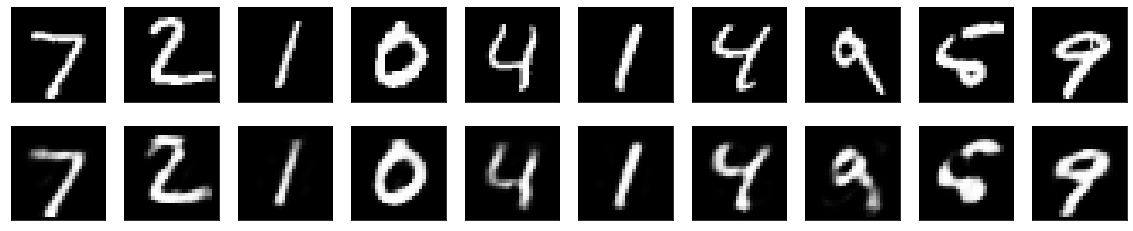

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
